# Data Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read the data
df = pd.read_csv('synthetic_insurance_data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 10000 non-null  int64 
 1   Is_Senior                           10000 non-null  int64 
 2   Marital_Status                      10000 non-null  object
 3   Married_Premium_Discount            10000 non-null  int64 
 4   Prior_Insurance                     10000 non-null  object
 5   Prior_Insurance_Premium_Adjustment  10000 non-null  int64 
 6   Claims_Frequency                    10000 non-null  int64 
 7   Claims_Severity                     10000 non-null  object
 8   Claims_Adjustment                   10000 non-null  int64 
 9   Policy_Type                         10000 non-null  object
 10  Policy_Adjustment                   10000 non-null  int64 
 11  Premium_Amount                      10000 non-null  int

We observed that there's some data have redundant columns, need to discard them.

Besides that, We also observed that there's data that are in String datatype, to makes our calculation easier, we will encoded it.

In [3]:
# Feature reduction
df = df.drop(['Married_Premium_Discount','Safe_Driver_Discount', 'Multi_Policy_Discount', 'Bundling_Discount'], axis=1) # Since there already exist a column for total discount

# Label encoding
# 0 for single, 1 for married, 2 for divorced, 3 for widowed (Nominal data)
marital_status_mapping = {
    'Single': 0,
    'Married': 1,
    'Divorced': 2,
    'Widowed': 3
}

df["Marital_Status"] = df["Marital_Status"].astype('category').map(marital_status_mapping)

# 0 for No prior insurance, 1 for <1 years, 2 for 1-5 years, 3 for >5 years (Ordinal data)
prior_insurance_mapping = {
    'No': 0,
    '<1 year': 1,
    '1-5 years': 2,
    '>5 years': 3
}

df['Prior_Insurance'] = df['Prior_Insurance'].astype('category').map(prior_insurance_mapping)

# 0 for Low severity, 1 for Medium severity, 2 for High severity (Ordinal data)
claims_severity_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

df['Claims_Severity'] = df['Claims_Severity'].astype('category').map(claims_severity_mapping)

# 0 for Full coverage, 1 for Liability-Only (Nominal data)
policy_type_mapping = {
    'Full Coverage': 0,
    'Liability-Only': 1
}

df['Policy_Type'] = df['Policy_Type'].astype('category').map(policy_type_mapping)

# 0 for Online, 1 for Agent, 2 for Referral (Nominal data)
source_of_lead_mapping = {
    'Online': 0,
    'Agent': 1,
    'Referral': 2
}

df['Source_of_Lead'] = df['Source_of_Lead'].astype('category').map(source_of_lead_mapping)

# 0 for Urban, 1 for Suburban, 2 for Rural (Nominal data)
region_mapping = {
    'Urban': 0,
    'Suburban': 1,
    'Rural': 2
}

df['Region'] = df['Region'].astype('category').map(region_mapping)


# Result after mapping / encoding
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Age                                 10000 non-null  int64   
 1   Is_Senior                           10000 non-null  int64   
 2   Marital_Status                      10000 non-null  category
 3   Prior_Insurance                     10000 non-null  category
 4   Prior_Insurance_Premium_Adjustment  10000 non-null  int64   
 5   Claims_Frequency                    10000 non-null  int64   
 6   Claims_Severity                     10000 non-null  category
 7   Claims_Adjustment                   10000 non-null  int64   
 8   Policy_Type                         10000 non-null  category
 9   Policy_Adjustment                   10000 non-null  int64   
 10  Premium_Amount                      10000 non-null  int64   
 11  Total_Discounts              

In [4]:
# Feature selection using RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['Premium_Amount'], axis=1)
features_name = X.columns
Y = df['Premium_Amount']

model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X, Y)

selected_features = features_name[rfe.support_]

print("Selected Features: ", selected_features)
print("Feature Ranking: ", rfe.ranking_)

Selected Features:  Index(['Age', 'Marital_Status', 'Prior_Insurance_Premium_Adjustment',
       'Claims_Adjustment', 'Policy_Adjustment', 'Total_Discounts',
       'Time_Since_First_Contact', 'Website_Visits', 'Credit_Score',
       'Premium_Adjustment_Region'],
      dtype='object')
Feature Ranking:  [ 1 13  1  4  1  6  8  1  9  1  1 11  1 12  1  3  7  2  1 10  5  1]


In [5]:
# After consideration, we use only the following features, since they are the most relevant and directly affect the premium amount
selected_features = ['Age', 'Prior_Insurance', 'Claims_Adjustment', 'Policy_Type', 'Total_Discounts', 'Credit_Score', 'Premium_Adjustment_Region']

print(selected_features)

df = df[selected_features + ['Premium_Amount']]

['Age', 'Prior_Insurance', 'Claims_Adjustment', 'Policy_Type', 'Total_Discounts', 'Credit_Score', 'Premium_Adjustment_Region']


Standardization and visualize the data

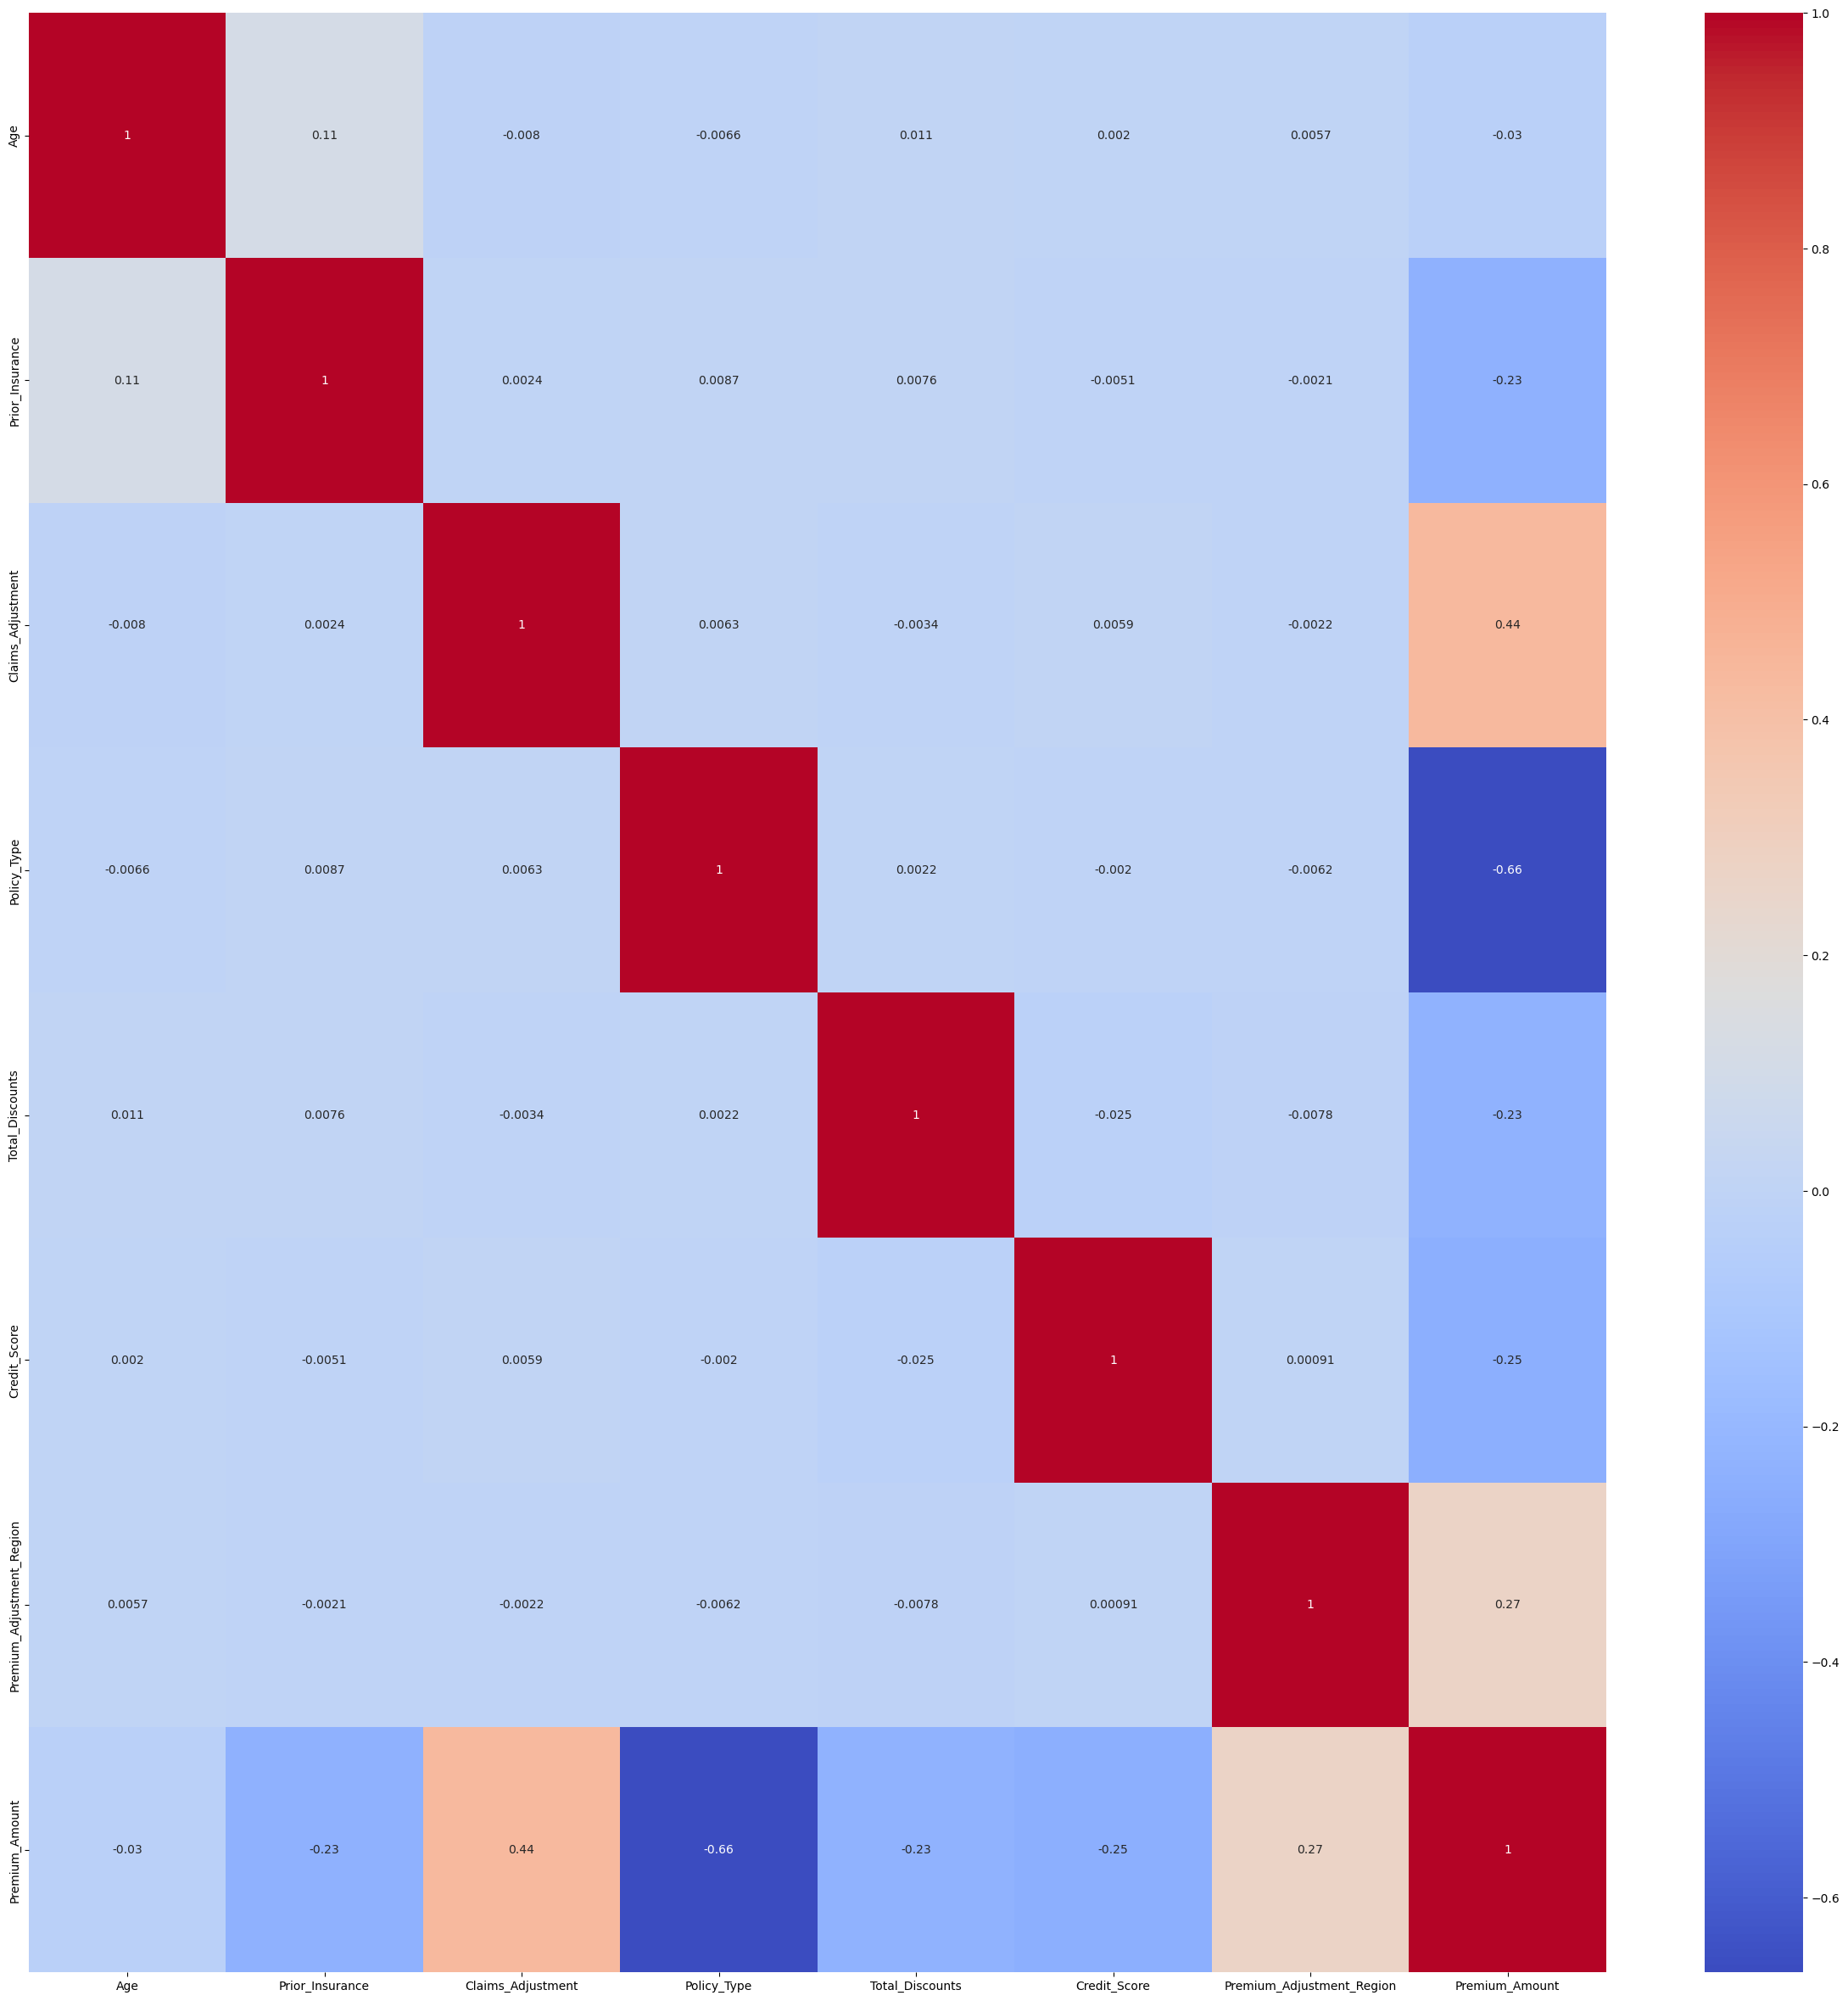

In [6]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

corr = df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [7]:
# Save the data to a new csv file
df.to_csv('processed_predict_premium_amount.csv', index=False)

# Model Selection

Load the data

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

scaler = StandardScaler()
selected_features = ['Age', 'Prior_Insurance', 'Claims_Adjustment', 'Policy_Type', 'Total_Discounts', 'Credit_Score', 'Premium_Adjustment_Region']

df = pd.read_csv('processed_predict_premium_amount.csv')
scaler.fit(df[selected_features])
df_no_outliers = df.copy()
z_score = np.abs(stats.zscore(df_no_outliers['Premium_Amount']))

print(z_score) # We get the Series of Premium Amount Z-score

df_no_outliers = df_no_outliers[z_score <= 2] # CI 95% for Z-score is 1.96, the z-score value above 2 in Premium_Amount is considered as an outlier

print(df_no_outliers) # We reduce the data from 10000 rows to 9640 rows

df_no_outliers[selected_features] = scaler.inverse_transform(df_no_outliers[selected_features]) # Inverse the standardization

0       0.447289
1       0.783959
2       1.120628
3       0.783959
4       0.878226
          ...   
9995    0.204887
9996    1.457297
9997    1.793966
9998    0.468451
9999    1.478459
Name: Premium_Amount, Length: 10000, dtype: float64
           Age  Prior_Insurance  Claims_Adjustment  Policy_Type  \
0     0.498824        -0.069136          -0.558059    -0.815306   
1    -0.212938        -0.069136          -0.558059    -0.815306   
2     0.641176        -0.069136           0.200586    -0.815306   
3     1.566465         1.386353           0.200586    -0.815306   
4    -0.284114         1.386353           0.959231    -0.815306   
...        ...              ...                ...          ...   
9995  1.352937        -0.069136          -0.558059    -0.815306   
9996 -1.565284        -0.069136          -0.558059    -0.815306   
9997 -0.782347        -1.524625          -0.558059    -0.815306   
9998  0.498824        -1.524625          -0.558059     1.226533   
9999  0.641176        -0

## Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

model = LinearRegression()

Machine Learning Experiment

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

# Fit the model for data without outliers
X = df_no_outliers.drop(['Premium_Amount'], axis=1)
Y = df_no_outliers['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("Without Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df_no_outliers['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred), '\n\n')

# Fit the model for data with outliers
df[selected_features] = scaler.inverse_transform(df[selected_features])
X = df.drop(['Premium_Amount'], axis=1)
Y = df['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("With Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df_no_outliers['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred))

Without Outliers: 
Cross Validation Scores:  [-2745.29178715 -2560.39136373 -2658.31089273 -2759.02752857
 -2644.44117326]
Mean CV Score:  -2673.4925490890682
Mean of the Premium Amount:  2216.6041493775933 


mean_squared_error:  2779.456207162892
R2 Score:  0.8489048357128073
Mean Absolute Error:  43.8472073728816 


With Outliers: 
Cross Validation Scores:  [-2663.24584122 -2790.40876443 -2697.20250718 -2776.42638233
 -2734.77583768]
Mean CV Score:  -2732.4118665691894
Mean of the Premium Amount:  2216.6041493775933 


mean_squared_error:  2742.8175065840087
R2 Score:  0.8819673600105762
Mean Absolute Error:  43.861851037516054


We observed that cut off the outliers does not bring significant improvement, instead it become worse. Hence we decide to keep the data with outliers

Visualize the actual and predict

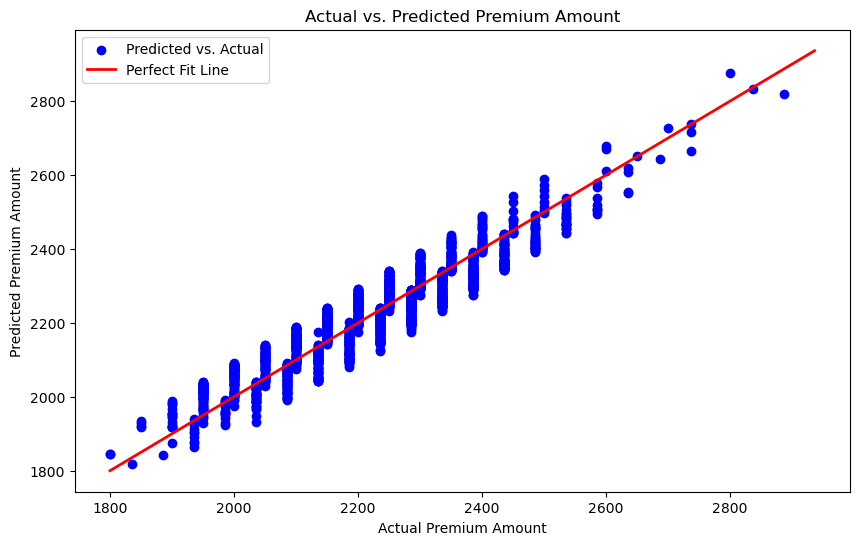

In [11]:
# Plotting the actual vs. predicted premium amounts
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs. Actual')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linewidth=2, label='Perfect Fit Line')
plt.xlabel('Actual Premium Amount')
plt.ylabel('Predicted Premium Amount')
plt.legend()
plt.title('Actual vs. Predicted Premium Amount')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_1248\1633644330.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10')  # You can choose other colormaps like 'viridis', 'plasma', etc.


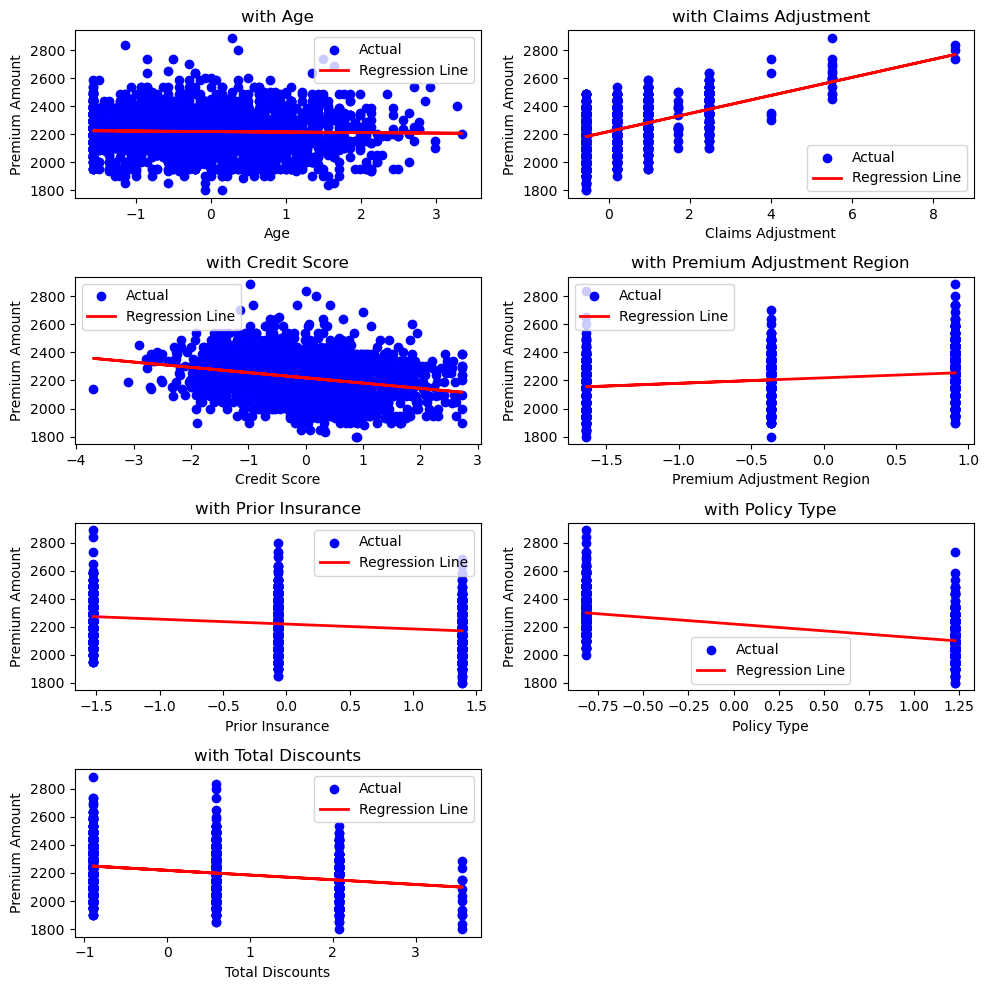

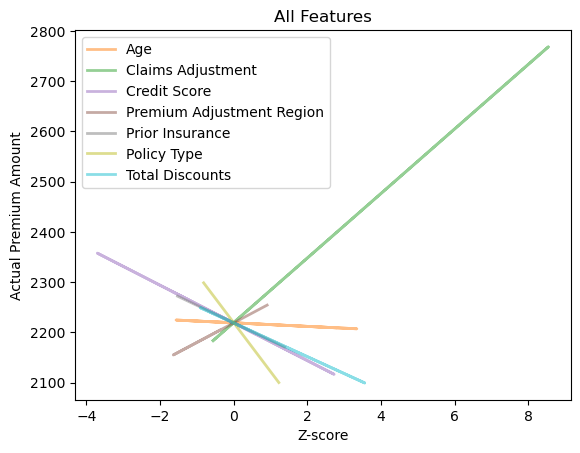

In [12]:
# Plotting the linear regression for each feature
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Define a colormap
colormap = plt.cm.get_cmap('tab10')  # You can choose other colormaps like 'viridis', 'plasma', etc.
colors = colormap(np.linspace(0, 1, 8))  # Adjust the number based on how many colors you need

def plot_linear_regression(x, y_actual, feature_name, xlabel, title, subplot_index):
    # Fits and trains the model
    model.fit(X_train[[feature_name]], Y_train)
    Y_pred = model.predict(X_test[[feature_name]])

    plt.subplot(4, 2, subplot_index)
    plt.scatter(x, y_actual, color='blue', label='Actual')
    plt.plot(x, Y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel(xlabel)
    plt.ylabel('Premium Amount')
    plt.legend()
    plt.title(title)

plot_linear_regression(X_test['Age'], Y_test, 'Age', 'Age', 'with Age', 1)
plot_linear_regression(X_test['Claims_Adjustment'], Y_test, 'Claims_Adjustment', 'Claims Adjustment', 'with Claims Adjustment', 2)
plot_linear_regression(X_test['Credit_Score'], Y_test, 'Credit_Score', 'Credit Score', 'with Credit Score', 3)
plot_linear_regression(X_test['Premium_Adjustment_Region'], Y_test, 'Premium_Adjustment_Region', 'Premium Adjustment Region', 'with Premium Adjustment Region', 4)
plot_linear_regression(X_test['Prior_Insurance'], Y_test, 'Prior_Insurance', 'Prior Insurance', 'with Prior Insurance', 5)
plot_linear_regression(X_test['Policy_Type'], Y_test, 'Policy_Type', 'Policy Type', 'with Policy Type', 6)
plot_linear_regression(X_test['Total_Discounts'], Y_test, 'Total_Discounts', 'Total Discounts', 'with Total Discounts', 7)

plt.tight_layout()
plt.show()

# All features
df = pd.read_csv('processed_insurance_data.csv')
X = df.drop(['Premium_Amount'], axis=1)
Y = df['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

plt.figure()
def plot_all_linear_regression(x, feature_name, xlabel, subplot_index):
    # Fits and trains the model
    model.fit(X_train[[feature_name]], Y_train)
    Y_pred = model.predict(X_test[[feature_name]])

    plt.plot(x, Y_pred, color=colors[subplot_index], linewidth=2, label=xlabel, alpha=0.5)
    plt.xlabel('Z-score')
    plt.ylabel('Actual Premium Amount')
    plt.legend()
    plt.title('All Features')


plot_all_linear_regression(X_test['Age'], 'Age', 'Age', 1)
plot_all_linear_regression(X_test['Claims_Adjustment'], 'Claims_Adjustment', 'Claims Adjustment', 2)
plot_all_linear_regression(X_test['Credit_Score'], 'Credit_Score', 'Credit Score', 3)
plot_all_linear_regression(X_test['Premium_Adjustment_Region'], 'Premium_Adjustment_Region', 'Premium Adjustment Region', 4)
plot_all_linear_regression(X_test['Prior_Insurance'], 'Prior_Insurance', 'Prior Insurance', 5)
plot_all_linear_regression(X_test['Policy_Type'], 'Policy_Type', 'Policy Type', 6)
plot_all_linear_regression(X_test['Total_Discounts'], 'Total_Discounts', 'Total Discounts', 7)
plt.show()

Conclusion for Linear Regression

Using Linear Regression in predicting premium amount have high accuracy (r2 score = 0.88), and the mean absolutely error is ±43.86.

## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge

model = Ridge()

Machine Learning Experiment

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Fit the model for data without outliers
X = df_no_outliers.drop(['Premium_Amount'], axis=1)
Y = df_no_outliers['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("Without Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df_no_outliers['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred), '\n\n')

# Fit the model for data with outliers
X = df.drop(['Premium_Amount'], axis=1)
Y = df['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("With Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred), '\n\n')

Without Outliers: 
Cross Validation Scores:  [-2745.34785172 -2560.38008787 -2658.29463863 -2759.12872882
 -2644.31216318]
Mean CV Score:  -2673.4926940425335
Mean of the Premium Amount:  2216.6041493775933 


mean_squared_error:  2779.4547630621337
R2 Score:  0.8489049142161638
Mean Absolute Error:  43.84774172373634 


With Outliers: 
Cross Validation Scores:  [-2663.2853724  -2790.36830327 -2697.18038146 -2776.48839381
 -2734.73366016]
Mean CV Score:  -2732.411222220208
Mean of the Premium Amount:  2219.5714 


mean_squared_error:  2742.891595011711
R2 Score:  0.8819641717369513
Mean Absolute Error:  43.862488164139506 




We observed that cut off the outliers does not bring significant improvement, instead it become worse. Ridge Regression brings a very similiar result with Linear Regression, which states that Ridge Regression does not bring significant improvement, hence we will not do further modeling for it.

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Fit the model for data without outliers
X = df_no_outliers.drop(['Premium_Amount'], axis=1)
Y = df_no_outliers['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("Without Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df_no_outliers['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred), '\n\n')

# Fit the model for data with outliers
X = df.drop(['Premium_Amount'], axis=1)
Y = df['Premium_Amount']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error') # In this case we using negative MSE to get positive value
print("With Outliers: ")
print("Cross Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Mean of the Premium Amount: ", df['Premium_Amount'].mean(), '\n\n')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('mean_squared_error: ', mean_squared_error(Y_test, Y_pred))
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred), '\n\n')

Without Outliers: 
Cross Validation Scores:  [-4020.39209332 -3935.59688918 -4008.38326848 -3899.38715953
 -3833.38132296]
Mean CV Score:  -3939.4281466948764
Mean of the Premium Amount:  2216.6041493775933 


mean_squared_error:  3959.783195020747
R2 Score:  0.7847405939149374
Mean Absolute Error:  45.05705394190871 


With Outliers: 
Cross Validation Scores:  [-3934.310625 -4147.226875 -3856.175    -4188.120625 -3901.156875]
Mean CV Score:  -4005.398
Mean of the Premium Amount:  2219.5714 


mean_squared_error:  3987.6175
R2 Score:  0.8283994397501087
Mean Absolute Error:  45.9245 




We observed that cut off the outliers does not bring significant improvement, instead it become worse. Decision Tree Regression brings a very similiar result with Linear Regression, which states that Decision Tree Regression does not bring significant improvement, hence we will not do further modeling for it.